# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_nopercolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 10, 10
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = []
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8291 - accuracy: 0.7257

947/947 [==============================] - 5724s 6s/step - loss: 0.8291 - accuracy: 0.7257 - val_loss: 0.7344 - val_accuracy: 0.7562
Epoch 2/200
947/947 [==============================] - 4816s 5s/step - loss: 0.7194 - accuracy: 0.7512 - val_loss: 0.7500 - val_accuracy: 0.7576
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6665 - accuracy: 0.7688

947/947 [==============================] - 5227s 6s/step - loss: 0.6665 - accuracy: 0.7688 - val_loss: 0.7002 - val_accuracy: 0.7586
Epoch 4/200
947/947 [==============================] - 4849s 5s/step - loss: 0.6403 - accuracy: 0.7784 - val_loss: 0.7098 - val_accuracy: 0.7571
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.6003 - accuracy: 0.7915

947/947 [==============================] - 5211s 6s/step - loss: 0.6003 - accuracy: 0.7915 - val_loss: 0.6123 - val_accuracy: 0.7846
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 0.5745 - accuracy: 0.7998

947/947 [==============================] - 5209s 5s/step - loss: 0.5745 - accuracy: 0.7998 - val_loss: 0.5465 - val_accuracy: 0.8033
Epoch 7/200
947/947 [==============================] - 4811s 5s/step - loss: 0.5547 - accuracy: 0.8037 - val_loss: 0.6064 - val_accuracy: 0.7850
Epoch 8/200
947/947 [==============================] - 4818s 5s/step - loss: 0.5404 - accuracy: 0.8099 - val_loss: 0.6338 - val_accuracy: 0.7855
Epoch 9/200
947/947 [==============================] - 4814s 5s/step - loss: 0.5427 - accuracy: 0.8110 - val_loss: 0.6028 - val_accuracy: 0.7953
Epoch 10/200
947/947 [==============================] - 4816s 5s/step - loss: 0.5064 - accuracy: 0.8194 - val_loss: 3.5806 - val_accuracy: 0.6846
Epoch 11/200
947/947 [==============================] - 4816s 5s/step - loss: 0.4863 - accuracy: 0.8264 - val_loss: 0.5886 - val_accuracy: 0.7982
Epoch 12/200
947/947 [==============================] - 4819s 5s/step - loss: 0.4701 - accuracy: 0.8306 - val_loss: 0.5563 - val_accuracy: 0

947/947 [==============================] - 5231s 6s/step - loss: 0.4536 - accuracy: 0.8386 - val_loss: 0.4798 - val_accuracy: 0.8288
Epoch 14/200
947/947 [==============================] - 4820s 5s/step - loss: 0.4385 - accuracy: 0.8428 - val_loss: 0.5800 - val_accuracy: 0.8098
Epoch 15/200
947/947 [==============================] - ETA: 0s - loss: 0.4345 - accuracy: 0.8450

947/947 [==============================] - 5218s 6s/step - loss: 0.4345 - accuracy: 0.8450 - val_loss: 0.4745 - val_accuracy: 0.8299
Epoch 16/200
947/947 [==============================] - 4816s 5s/step - loss: 0.4311 - accuracy: 0.8470 - val_loss: 0.7095 - val_accuracy: 0.8011
Epoch 17/200
947/947 [==============================] - 4821s 5s/step - loss: 0.4012 - accuracy: 0.8543 - val_loss: 0.5112 - val_accuracy: 0.8251
Epoch 18/200
947/947 [==============================] - 4820s 5s/step - loss: 0.3915 - accuracy: 0.8588 - val_loss: 0.5131 - val_accuracy: 0.8316
Epoch 19/200
947/947 [==============================] - 4820s 5s/step - loss: 0.3784 - accuracy: 0.8641 - val_loss: 0.4846 - val_accuracy: 0.8308
Epoch 20/200
947/947 [==============================] - 4820s 5s/step - loss: 0.3800 - accuracy: 0.8627 - val_loss: 0.8361 - val_accuracy: 0.7946
Epoch 21/200
947/947 [==============================] - 4817s 5s/step - loss: 0.4104 - accuracy: 0.8533 - val_loss: 0.5217 - val_accuracy

947/947 [==============================] - 5218s 6s/step - loss: 0.3763 - accuracy: 0.8658 - val_loss: 0.4656 - val_accuracy: 0.8386
Epoch 24/200
947/947 [==============================] - 4817s 5s/step - loss: 0.3325 - accuracy: 0.8769 - val_loss: 0.5018 - val_accuracy: 0.8338
Epoch 25/200
947/947 [==============================] - ETA: 0s - loss: 0.3201 - accuracy: 0.8825

947/947 [==============================] - 5224s 6s/step - loss: 0.3201 - accuracy: 0.8825 - val_loss: 0.4449 - val_accuracy: 0.8366
Epoch 26/200
947/947 [==============================] - 4818s 5s/step - loss: 0.3079 - accuracy: 0.8876 - val_loss: 0.4588 - val_accuracy: 0.8436
Epoch 27/200
947/947 [==============================] - 4821s 5s/step - loss: 0.2998 - accuracy: 0.8900 - val_loss: 0.5465 - val_accuracy: 0.8272
Epoch 28/200
947/947 [==============================] - 4821s 5s/step - loss: 0.2882 - accuracy: 0.8946 - val_loss: 0.4925 - val_accuracy: 0.8371
Epoch 29/200
947/947 [==============================] - 4819s 5s/step - loss: 0.2794 - accuracy: 0.8968 - val_loss: 0.4492 - val_accuracy: 0.8559
Epoch 30/200
947/947 [==============================] - 4817s 5s/step - loss: 0.2705 - accuracy: 0.9002 - val_loss: 0.5143 - val_accuracy: 0.8353
Epoch 31/200
947/947 [==============================] - ETA: 0s - loss: 0.2608 - accuracy: 0.9057

947/947 [==============================] - 5211s 6s/step - loss: 0.2608 - accuracy: 0.9057 - val_loss: 0.4355 - val_accuracy: 0.8551
Epoch 32/200
947/947 [==============================] - 4820s 5s/step - loss: 0.2519 - accuracy: 0.9078 - val_loss: 0.7842 - val_accuracy: 0.8312
Epoch 33/200
947/947 [==============================] - 4916s 5s/step - loss: 0.2443 - accuracy: 0.9098 - val_loss: 0.6319 - val_accuracy: 0.8242
Epoch 34/200
947/947 [==============================] - 4904s 5s/step - loss: 0.2364 - accuracy: 0.9128 - val_loss: 0.4706 - val_accuracy: 0.8509
Epoch 35/200
947/947 [==============================] - 4915s 5s/step - loss: 0.2261 - accuracy: 0.9152 - val_loss: 0.5657 - val_accuracy: 0.8338
Epoch 36/200
947/947 [==============================] - 4899s 5s/step - loss: 0.2376 - accuracy: 0.9131 - val_loss: 0.5556 - val_accuracy: 0.8312
Epoch 37/200
947/947 [==============================] - 4916s 5s/step - loss: 0.2170 - accuracy: 0.9190 - val_loss: 0.4819 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 558s 3s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9713201651601384,
 'basal cell carcinoma': 0.9886113257218073,
 'dermatofibroma': 0.9917508417508417,
 'melanoma': 0.9412589883489888,
 'nevus': 0.9679161004579998,
 'pigmented benign keratosis': 0.9870434177362944,
 'seborrheic keratosis': 0.9647764254965282,
 'solar lentigo': 0.9592063422921113,
 'squamous cell carcinoma': 0.9702757013101841,
 'vascular lesion': 0.9997895743663319}

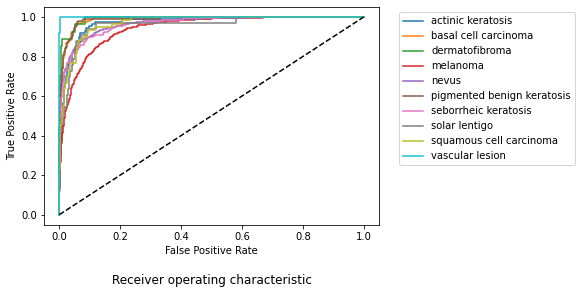

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

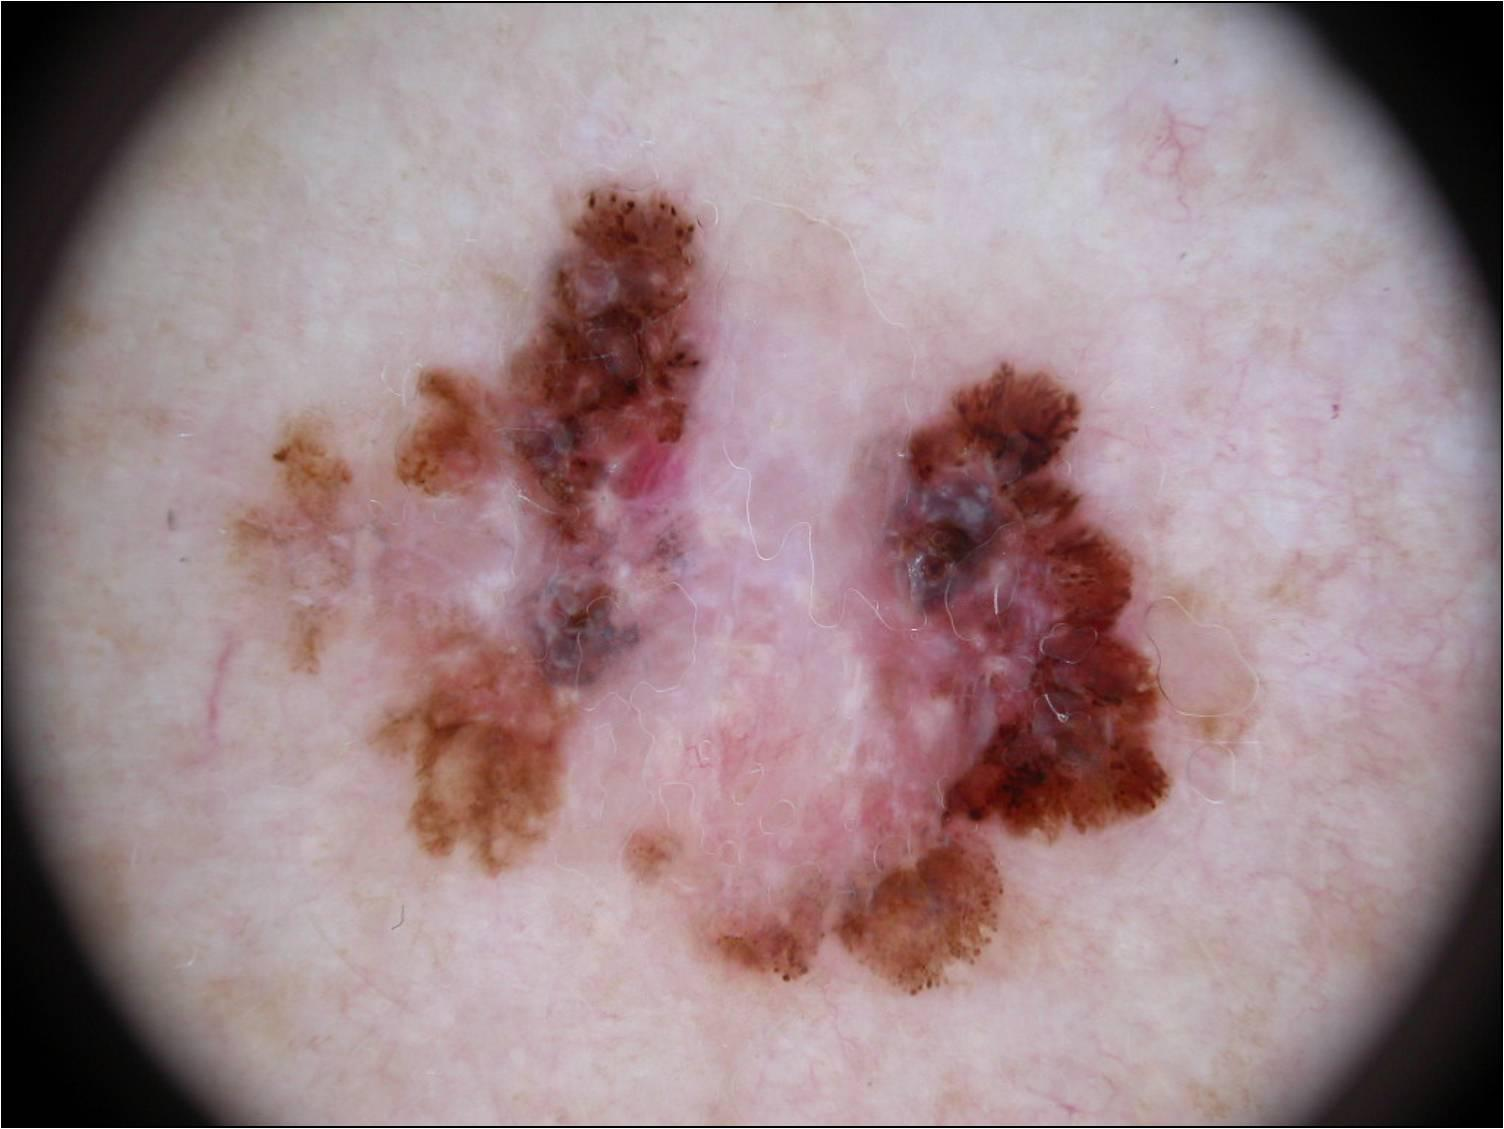

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, 'conv_7b')

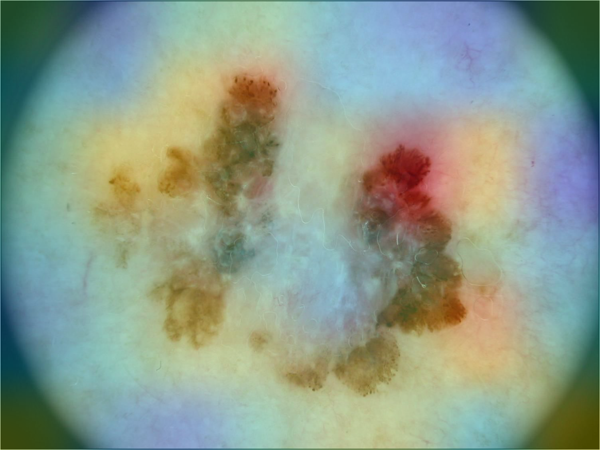

In [23]:
display_gradcam(melanoma_im_path, heatmap)